## Hidden Markov Model

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('MSFT.csv')
data

,date,Open,High,Low,closing_price,Adj Close,Volume
0,13/03/1986,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1,14/03/1986,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
2,17/03/1986,0.100694,0.103299,0.100694,0.102431,0.064384,133171200
3,18/03/1986,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
4,19/03/1986,0.099826,0.100694,0.097222,0.098090,0.061655,47894400
...,...,...,...,...,...,...,...
9160,18/07/2022,259.750000,260.839996,253.300003,254.250000,254.250000,20975000
9161,19/07/2022,257.579987,259.720001,253.679993,259.529999,259.529999,25012600
9162,20/07/2022,259.899994,264.869995,258.910004,262.269989,262.269989,22788300
9163,21/07/2022,259.790009,264.890015,257.029999,264.839996,264.839996,22404700


In [ ]:
data.head()

,date,Open,High,Low,closing_price,Adj Close,Volume
0,13/03/1986,0.088542,0.101563,0.088542,0.097222,0.061109,1031788800
1,14/03/1986,0.097222,0.102431,0.097222,0.100694,0.063292,308160000
2,17/03/1986,0.100694,0.103299,0.100694,0.102431,0.064384,133171200
3,18/03/1986,0.102431,0.103299,0.098958,0.099826,0.062746,67766400
4,19/03/1986,0.099826,0.100694,0.097222,0.098090,0.061655,47894400


In [ ]:
data.shape

(9165, 7)

### Train-test split

For all data, we are going to do a 80-20 train-test split.

In [ ]:
train_size = int(0.8*data.shape[0])
print(train_size)

7332


In [ ]:
train_data = data.iloc[0:train_size]
test_data = data.iloc[train_size+1:]

### Extracting features



We are going to be working with 3 features:
1. The fractional change in opening and closing prices (fracocp)
2. The fractional change in high prices (frachp)
3. The fractional change in low prices (fraclp)

These will be obtained individually in the train and test datasets.

In [ ]:
def augment_features(dataframe):
    fracocp = (dataframe['closing_price']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)
    
    return new_dataframe

In [ ]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [ ]:
features = extract_features(augment_features(train_data))

In [ ]:
features.shape

(7332, 3)

## Hidden Markov Models with hmmlearn

### Model

We are first going to import the GaussianHMM from hmmlearn.hmm and then fit it with 10 hidden components (or states) to our training data. We start off with 10 hidden states, but it may be possible to do a grid search among a possible set of values for the number of hidden states to see which works the best.

In [ ]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 129 kB 5.1 MB/s 


In [ ]:
from hmmlearn.hmm import GaussianHMM

In [ ]:
model = GaussianHMM(n_components=10)

In [ ]:
feature_train_data = augment_features(train_data)
features_train = extract_features(feature_train_data)
model.fit(features_train)

GaussianHMM(n_components=10)

### Generating possible sequences

To generate possible possible permutations of values for the features we take the Cartesian product across a range of values for each feature as seen below. We assume a few things here to reduce model complexity.
1. We assume that the distribution of each features is across an evenely spaced interval instead of being fully continuous
2. We assume possible values for the start and end of the intervals

In [ ]:
import itertools

test_augmented = augment_features(test_data)
fracocp = test_augmented['delOpenClose']
frachp = test_augmented['delHighOpen']
fraclp = test_augmented['delLowOpen']

sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

### Checking predictions

We use the data of the last 50 (latent) days to predict the closing price of the current day, and we repeat those for 300 days (this value does not matter at all)

In [ ]:
num_latent_days = 50
num_days_to_predict = 300

For each of the days that we are going to predict closing prices for, we are going to take the test data for the previous num_latent_days and try each of the outcomes in possible_outcomes to see which sequence generates the highest score. The outcome that generates the highest score is then used to make the predictions for that day's closing price.

In [ ]:
from tqdm import tqdm

predicted_close_prices = []
for i in tqdm(range(num_days_to_predict)):
    # Calculate start and end indices
    previous_data_start_index = max(0, i - num_latent_days)
    previous_data_end_index = max(0, i)
    # Acquire test data features for these days
    previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
    
    outcome_scores = []
    for outcome in possible_outcomes:
        # Append each outcome one by one with replacement to see which sequence generates the highest score
        total_data = np.row_stack((previous_data, outcome))
        outcome_scores.append(model.score(total_data))
        
    # Take the most probable outcome as the one with the highest score
    most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
    predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))

100%|██████████| 300/300 [13:19<00:00,  2.66s/it]


Plotting the predicted closing prices and the actual closing prices, we see the following

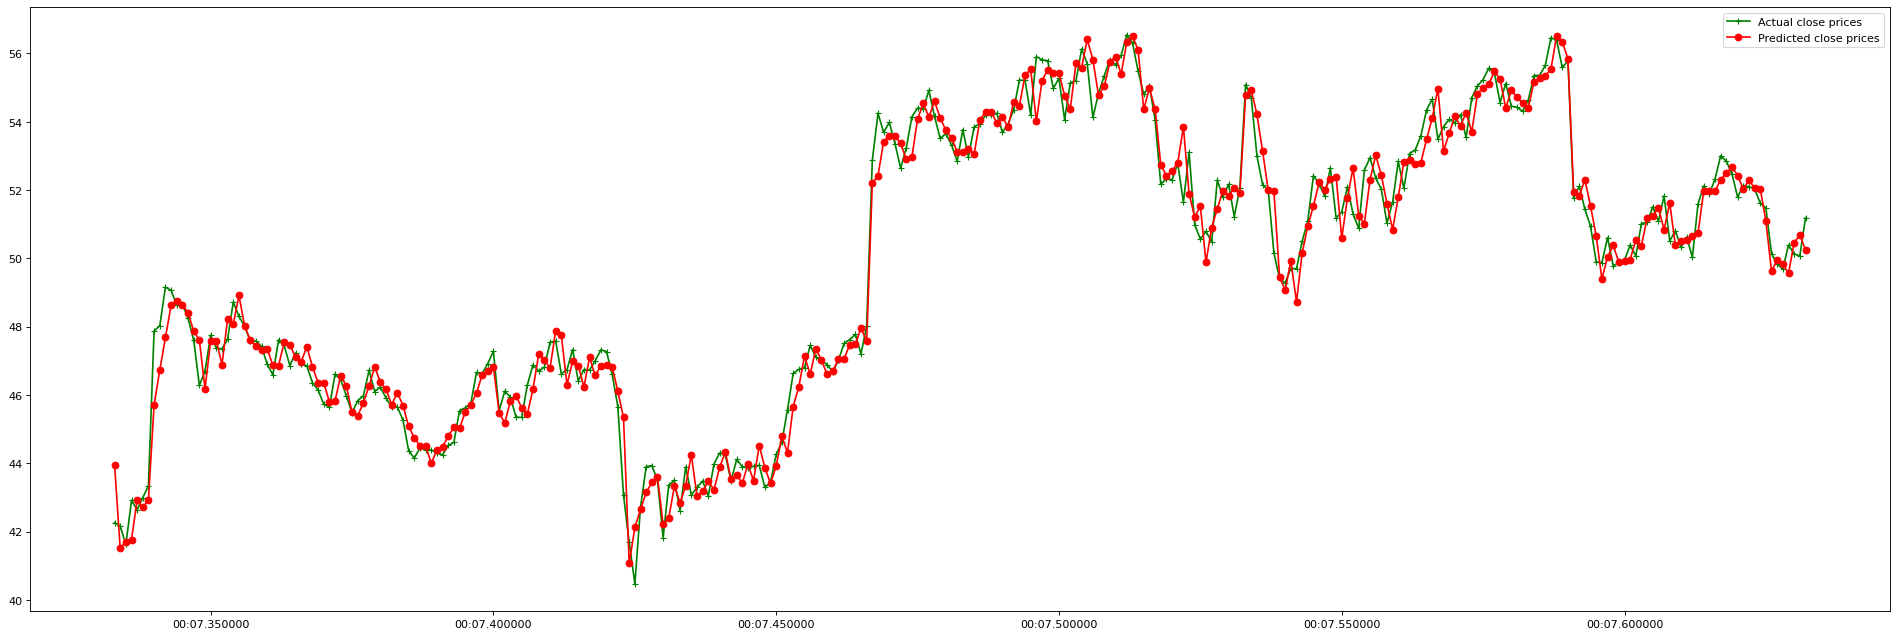

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), dpi=80)


x_axis = np.array(test_data.index[0:num_days_to_predict], dtype='datetime64[ms]')
plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['closing_price'], 'g+-', label="Actual close prices")
plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
plt.legend()
plt.show()

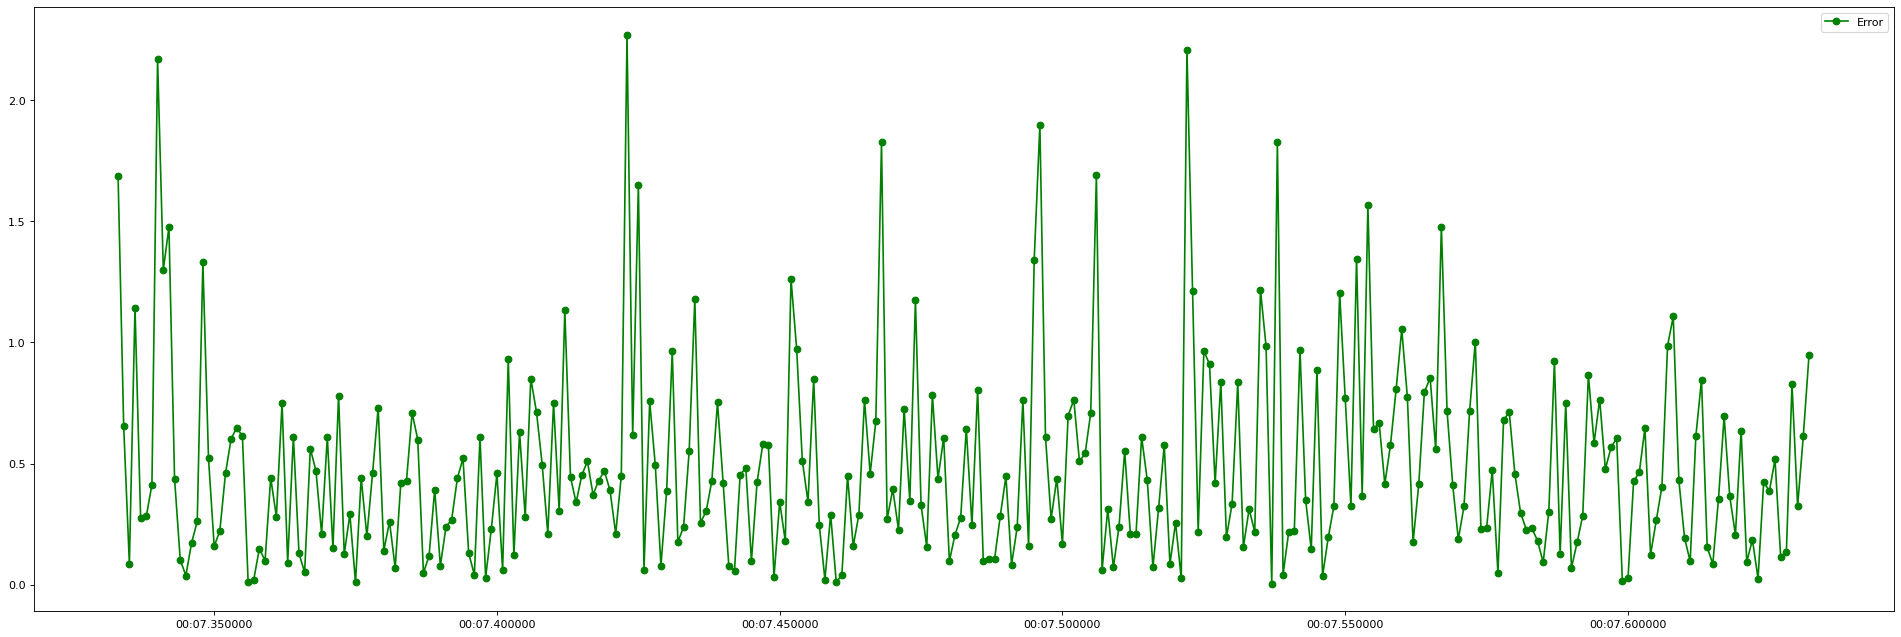

In [ ]:
ae = abs(test_data.iloc[0:num_days_to_predict]['closing_price'] - predicted_close_prices)
ae1 = ae * ae

plt.figure(figsize=(30,10), dpi=80)

plt.plot(x_axis, ae, 'go-', label="Error")
plt.legend()
plt.show()

In [ ]:
print("Max squeared error observed = " + str(ae1.max()))
print("Min squeared error observed = " + str(ae1.min()))
print("Mean Absolute error observed = " + str(ae.mean()))
print("Mean squeared error observed = " + str(ae1.mean()))


Max squeared error observed = 5.150143867113413
Min squeared error observed = 1.4745974396700325e-05
Mean Absolute error observed = 0.4855377532018684
Mean squeared error observed = 0.4040699809742932


In [ ]:
len(test_data)

1832

In [ ]:
from sklearn.metrics import mean_squared_error
rmse= np.sqrt(ae1.mean())
#print("RMSE for  =", rmse)
print("Root Mean squeared error observed = " , ae1.mean() ** 1/2)

Root Mean squeared error observed =  0.2020349904871466


The graphs above show that our model is fairly accurate in predicting the close prices. There is a maximum absolute error of 104.09, a minimum absolute error of 0.05 and a mean absolute error of 10.6812.76. The first graph also shows that thereare significant gaps between the predictions plot and the actual plot.

We also observe that the highest errors occur when the actual closing prices change very sharply (steep rise or fall).

However, we can say that our model is able to predict the general trends in the actual closing price movement fairly well, although there are lags observed from time to time.